<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 0 (0 баллов)

Сделать dataloader

In [1]:
LOAD_LIBS = True

In [2]:
if LOAD_LIBS:
  !pip install transformers -q
  !pip install datasets -q
  !pip install nltk -q
  import nltk
  nltk.download('stopwords')
  !pip install pymorphy2 -q

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.ticker as ticker
from transformers import get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from math import ceil
import pandas as pd

# datasets from huggingface
from transformers import BertTokenizer, BertModel, AutoTokenizer
from datasets import Dataset


from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
import nltk
import pymorphy2
import string
import re

import os
from datetime import datetime
from torch.nn.utils.rnn import pad_sequence

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

RUSSIAN_STOP_WORDS = set(stopwords.words('russian'))
PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer() # for preprocess
# for broadening your horizons use it for lemmatization
MORPH_ANALYZER = pymorphy2.MorphAnalyzer()

2024-04-12 08:51:44.002489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 08:51:44.002588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 08:51:44.150898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Скачиваем и предобрабатываем текст

In [4]:
def preprocess_text(text):
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    punct_filtered_text = ''.join(
        [ch for ch in nums_filtered_text if ch not in (string.punctuation + '–')]
    )
    tokens = PUNCT_WORD_TOKENIZER.tokenize(punct_filtered_text)
    filtr_stop_words_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens
                             if token not in RUSSIAN_STOP_WORDS ]
    norm_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in filtr_stop_words_tokens]

    return f"{' '.join(norm_tokens)}"

In [5]:
data = pd.read_excel('/kaggle/input/maths-tasks-in-russian/data_problems.xlsx')
labels = data['Тема']
data['Задача'] = data['Задача'].map(preprocess_text)
label_dict = {}
for i in range(7):
    label_dict[labels.unique()[i]] = i 
labels = labels.map(lambda x: label_dict[x])
data.drop(['Unnamed: 0', 'Тема'], axis=1, inplace=True)
data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=0.1)
data_train['label'] = label_train
data_train.rename({'Задача':'text'}, axis=1, inplace=True)
data_test['label'] = label_test
data_test.rename({'Задача':'text'}, axis=1, inplace=True)

## Смотрим на предобработанный текст

In [6]:
for i in range(20):
    print(data.iloc[i, 0])

девять планета солнечный система ввести космический сообщение ракета летать следующий маршрут земля меркурий плутон венера земля плутон плутон меркурий меркурий венера уран нептун нептун сатурн сатурн юпитер юпитер марс марс уран добраться земля марс
страна цифра город название путешественник обнаружить город соединить авиалиния случай двузначный число составить цифрназвание этот город делиться добраться город город
государство город каждый выходить дорога сколько дорога государство
класс человек иметь друг класс друг друг
город маленький телефон соединить проводы четыре телефон каждый который соединить три другой восемь телефон каждый который соединить шесть телефон каждый который соединить пять другой
страна семёрка город каждый который соединить дорога менее семья другой доказать каждый город добраться любой другой возможно проезжать другой город
иметься группа остров соединить мост каждый остров добраться любой другой турист обойти остров пройти каждый мост ровно остров троекратный

In [7]:
ds_train = Dataset.from_pandas(data_train)
ds_train = ds_train.remove_columns('__index_level_0__')
ds_test = Dataset.from_pandas(data_test)
ds_test = ds_test.remove_columns('__index_level_0__')
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 4745
})

In [8]:
def tokenize_function(examples):
    global tokenizer
    return tokenizer(
        examples["text"],
        padding="max_length",
        max_length=512,
        truncation=True,
        return_token_type_ids="token_type_ids" in tokenizer.model_input_names)

def ds_object_process(ds_obj):
    return ds_obj.map(
        tokenize_function, batched=True
      ).remove_columns(["text"]).rename_column("label", "labels")
tokenizer = 0
test_dataloader = 0

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [9]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str, n_classes: int):
        super(TransformerClassificationModel, self).__init__()
        
        if isinstance(base_transformer_model, str):
            self.backbone = BertModel.from_pretrained(base_transformer_model,
                                                     output_attentions=True)
        else:
            self.backbone = base_transformer_model
        
        self.n_classes = n_classes
        self.hidden_dim = self.backbone.config.hidden_size 
        
        self.linear = nn.Linear(self.hidden_dim, n_classes)
        
        self.tokenizer = AutoTokenizer.from_pretrained(base_transformer_model)

    def forward(self, inputs, attention_mask):
        outputs = self.backbone(inputs, attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.linear(pooled_output)
        return logits, outputs.attentions

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [10]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for w in model.backbone.parameters():
        w._trainable = False
    for w in model.linear.parameters():
        w._trainable = True

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [11]:
def length_to_mask(length, max_len=None, dtype=None):
    """length: B.
    return B x max_len.
    If max_len is None, then max of length will be used.
    """
    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask

In [12]:
def validation(epoch_number, val_dataloader, model, loss_fn):
    val_loss = 0.0

    all_answers = []
    answers_probs = []
    all_labels = []

    cnt_answers = 0
    cnt_right_answers = 0
    model.eval()
    
    with torch.no_grad():
        for i, vdata in tqdm(enumerate(val_dataloader)):
            #labels, input_data, _, lengths = vdata
            labels, input_data, attention_mask = vdata['labels'], vdata['input_ids'], vdata['attention_mask']
            #mask = length_to_mask(lengths)

            input_data = input_data.to(device)
            labels = labels.to(device).long()
            attention_mask = attention_mask.to(device)
            
            outputs, attention = model(input_data, attention_mask)

            vloss = loss_fn(outputs, labels)
            val_loss += vloss.item()
            answers = outputs.argmax(axis=-1)

            cnt_answers += labels.shape[0]
            cnt_right_answers += (answers == labels).sum().item()

            del input_data, labels

    val_loss = val_loss / len(val_dataloader)
    
    return val_loss, cnt_right_answers / cnt_answers

In [13]:
import copy

def train_transformer(transformer_model, 
                      freeze_backbone=True,
                      lr=0.00005,
                      num_epochs=4,
                      batch_size=8,
                      device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):  # Define device
    model = copy.deepcopy(transformer_model)
    model.to(device)  # Send model to device
    if freeze_backbone:
        freeze_backbone_function(model)
    global tokenizer, test_dataloader
    tokenizer = model.tokenizer
    
    tokenized_train_dataset = ds_object_process(ds_train)
    tokenized_train_dataset.set_format("torch")
    tokenized_test_dataset = ds_object_process(ds_test)
    tokenized_test_dataset.set_format("torch")
    
    train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=batch_size)
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=batch_size)

        
    num_training_steps = num_epochs*len(train_dataloader)
    progress_bar = tqdm(range(num_training_steps))
        
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)  # Fix the LR parameter name   
    scheduler = get_scheduler(
                    name="linear", optimizer=optimizer, num_warmup_steps=0, 
                    num_training_steps=num_training_steps
                             )
    
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch_number in range(num_epochs):
        train_loss = 0
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            model.train()
            inputs = batch['input_ids']
            labels = batch['labels'].long()  # No need to send labels to device again
            outputs, attention = model(inputs, attention_mask=batch['attention_mask'])
            
            loss = loss_fn(outputs, labels)  # Access logits from outputs
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        train_loss /= len(train_dataloader)
        
        
        val_loss, val_acc = validation(epoch_number, test_dataloader, model, loss_fn)
        
        print(f'EPOCH {epoch_number}: train_loss={train_loss}')
        print(f'EPOCH {epoch_number}: val_loss={val_loss}, val_acc={val_acc}')
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    return model, train_loss_list, val_loss_list, val_acc_list

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [15]:
rubert_tiny_transformer_model = TransformerClassificationModel('cointegrated/rubert-tiny2',
                                                               n_classes=7)
(rubert_tiny_finetuned_with_unfrozen_backbone, 
 train_loss_rubert, 
 val_loss_rubert, 
 val_acc_rubert
) = train_transformer(rubert_tiny_transformer_model, 
                    freeze_backbone=False,
                    lr=2e-5,
                    num_epochs=8,
                    batch_size=16)

Map:   0%|          | 0/4745 [00:00<?, ? examples/s]

Map:   0%|          | 0/528 [00:00<?, ? examples/s]

  0%|          | 0/2376 [00:00<?, ?it/s]

0it [00:00, ?it/s]

EPOCH 0: train_loss=1.3792468827180189
EPOCH 0: val_loss=1.1895864497531543, val_acc=0.5776515151515151


0it [00:00, ?it/s]

EPOCH 1: train_loss=1.0770140647486806
EPOCH 1: val_loss=1.054691903518908, val_acc=0.625


0it [00:00, ?it/s]

EPOCH 2: train_loss=0.9694810228717046
EPOCH 2: val_loss=0.9906200260827036, val_acc=0.6268939393939394


0it [00:00, ?it/s]

EPOCH 3: train_loss=0.9004269808229773
EPOCH 3: val_loss=0.961084681929964, val_acc=0.6231060606060606


0it [00:00, ?it/s]

EPOCH 4: train_loss=0.8491850532465912
EPOCH 4: val_loss=0.9454177970235998, val_acc=0.6193181818181818


0it [00:00, ?it/s]

EPOCH 5: train_loss=0.8175286092742123
EPOCH 5: val_loss=0.9411474972060232, val_acc=0.6193181818181818


0it [00:00, ?it/s]

EPOCH 6: train_loss=0.7922458532281997
EPOCH 6: val_loss=0.9363029743685867, val_acc=0.6193181818181818


0it [00:00, ?it/s]

EPOCH 7: train_loss=0.7712827392098077
EPOCH 7: val_loss=0.9376362517024531, val_acc=0.625


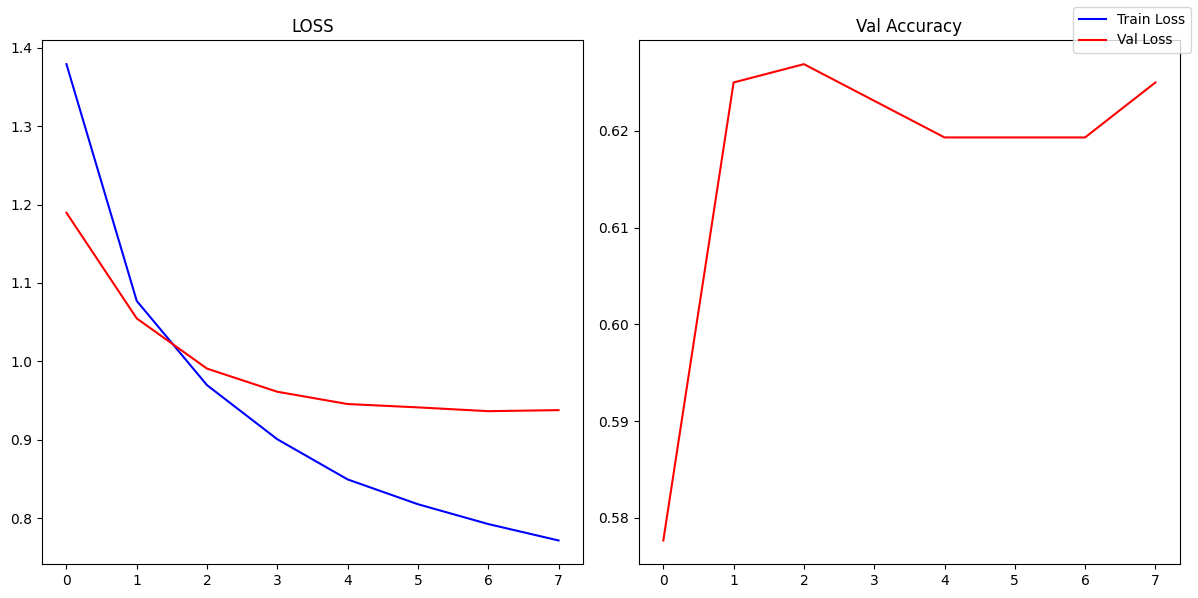

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(range(8), train_loss_rubert, color='b', label='Train Loss')
ax[0].plot(range(8), val_loss_rubert, color='r', label='Val Loss')
ax[0].set_title('LOSS')
ax[1].plot(range(8), val_acc_rubert, color='r')
ax[1].set_title('Val Accuracy')
     
plt.tight_layout()
fig.legend()
plt.show()

In [65]:
rubert_tiny_transformer_model = TransformerClassificationModel('cointegrated/rubert-tiny2',
                                                               n_classes=7)
(rubert_tiny_finetuned_with_frozen_backbone, 
 train_loss_rubert_freeze, 
 val_loss_rubert_freeze, 
 val_acc_rubert_freeze) = train_transformer(rubert_tiny_transformer_model, 
                                            freeze_backbone=True,
                                            lr=1e-5,
                                            num_epochs=8,
                                            batch_size=16
                                            )

Map:   0%|          | 0/4745 [00:00<?, ? examples/s]

Map:   0%|          | 0/528 [00:00<?, ? examples/s]

  0%|          | 0/2376 [00:00<?, ?it/s]

0it [00:00, ?it/s]

EPOCH 0: train_loss=1.5193317135175068
EPOCH 0: val_loss=1.346361593766646, val_acc=0.5170454545454546


0it [00:00, ?it/s]

EPOCH 1: train_loss=1.217512097021546
EPOCH 1: val_loss=1.1860401612339597, val_acc=0.5833333333333334


0it [00:00, ?it/s]

EPOCH 2: train_loss=1.1090346837685967
EPOCH 2: val_loss=1.1176685600569753, val_acc=0.5984848484848485


0it [00:00, ?it/s]

EPOCH 3: train_loss=1.0510108390641133
EPOCH 3: val_loss=1.0768397215640906, val_acc=0.6193181818181818


0it [00:00, ?it/s]

EPOCH 4: train_loss=1.0101163478612096
EPOCH 4: val_loss=1.0520351258191196, val_acc=0.6212121212121212


0it [00:00, ?it/s]

EPOCH 5: train_loss=0.9823008480698171
EPOCH 5: val_loss=1.0349447474335178, val_acc=0.6287878787878788


0it [00:00, ?it/s]

EPOCH 6: train_loss=0.9675513072447344
EPOCH 6: val_loss=1.027312412406459, val_acc=0.6306818181818182


0it [00:00, ?it/s]

EPOCH 7: train_loss=0.956489253124404
EPOCH 7: val_loss=1.0254302783445879, val_acc=0.6325757575757576


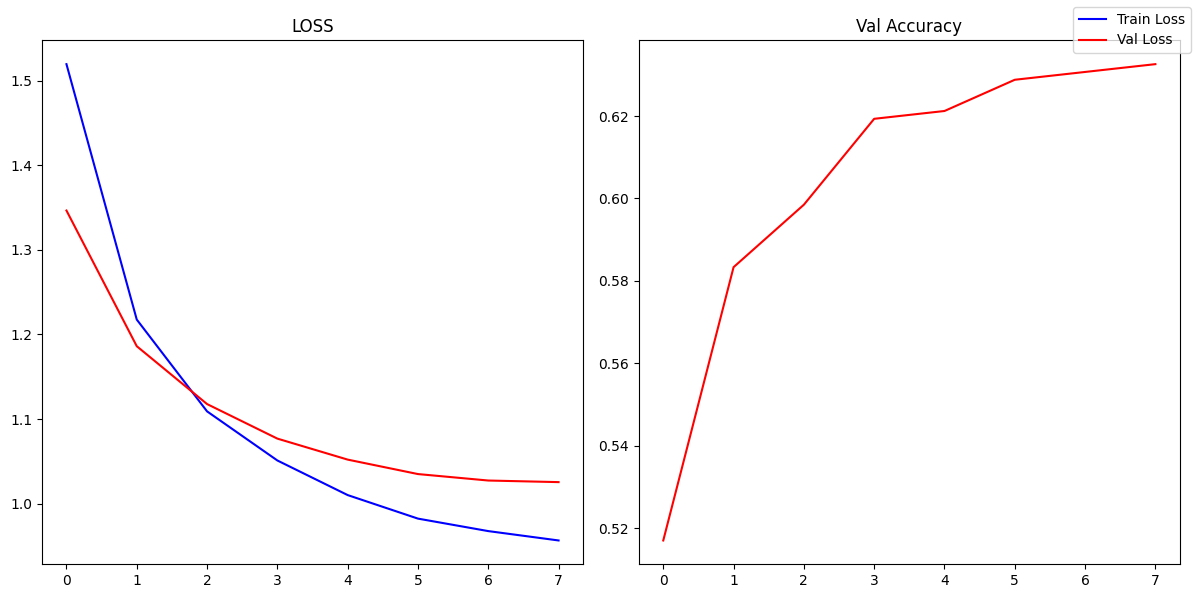

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(range(8), train_loss_rubert_freeze, color='b', label='Train Loss')
ax[0].plot(range(8), val_loss_rubert_freeze, color='r', label='Val Loss')
ax[0].set_title('LOSS')
ax[1].plot(range(8), val_acc_rubert_freeze, color='r')
ax[1].set_title('Val Accuracy')
     
plt.tight_layout()
fig.legend()
plt.show()

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [28]:
ten  = torch.tensor(np.array([1, 2, 3]))
ten[1] = torch.tensor(0)
ten

tensor([1, 0, 3])

In [52]:
def draw_first_layer_attention_maps(attention_head_ids: list, text: str, model: TransformerClassificationModel):
    global device, tokenizer
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        text = preprocess_text(text)
        #print(text)
        ds_indference = Dataset.from_dict({'text': [text], 'label':[1]})
        tokenizer = model.tokenizer

        tokenized_infer = ds_object_process(ds_indference)
        tokenized_infer.set_format("torch")
        tokenized_dl = DataLoader(tokenized_infer, batch_size=1)

        for batch in  tokenized_dl :
            input_data, attention_mask = batch['input_ids'], batch['attention_mask']

            input_data = input_data.to(device)
            attention_mask = attention_mask.to(device) 
            first_attention = model(input_data, attention_mask)[1][0][0]

        fig, ax = plt.subplots(nrows=ceil(len(attention_head_ids) / 2), ncols=2, figsize=(12, 6*ceil(len(attention_head_ids) / 2)))\
        
               
        for i in range(len(attention_head_ids)):
            text_length = torch.count_nonzero(input_data)
            text_token = input_data[0, :text_length]
            sentence = []
            for j in range(text_length):
                sentence.append(tokenizer.decode(text_token[j]))
        

            if ceil(len(attention_head_ids) / 2) != 1:
                sns.heatmap(first_attention[attention_head_ids[i]].cpu()[:text_length, :text_length], 
                            ax=ax[i // 2, i % 2],
                           xticklabels = sentence,
                           yticklabels = sentence,
                           ).set_title(f'Head {attention_head_ids[i]}')
            else:
                sns.heatmap(first_attention[attention_head_ids[i]].cpu()[:text_length, :text_length], 
                            ax=ax[i % 2],
                           xticklabels = sentence,
                           yticklabels = sentence,
                           ).set_title(f'Head {attention_head_ids[i]}')
            plt.tight_layout()



### Задание 7 (1 балл)

Проведите инференс для модели **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

Возьмём следующие id из test: 42, 84( 42*2) - 42 обычно используют как число для random_seed

In [61]:
texts_infer = [data_test.iloc[42].values[0], data_test.iloc[84].values[0]]
print(texts_infer)


['доказать найтись число вид несколько повторить число затем стоить несколько нуль делиться б делиться', 'доказать число n n иметь одинаковый сумма цифра n делиться']


## Rubert бeз finetuning

### Текст 1 

In [54]:
(texts_infer[0])

'доказать найтись число вид несколько повторить число затем стоить несколько нуль делиться б делиться'

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

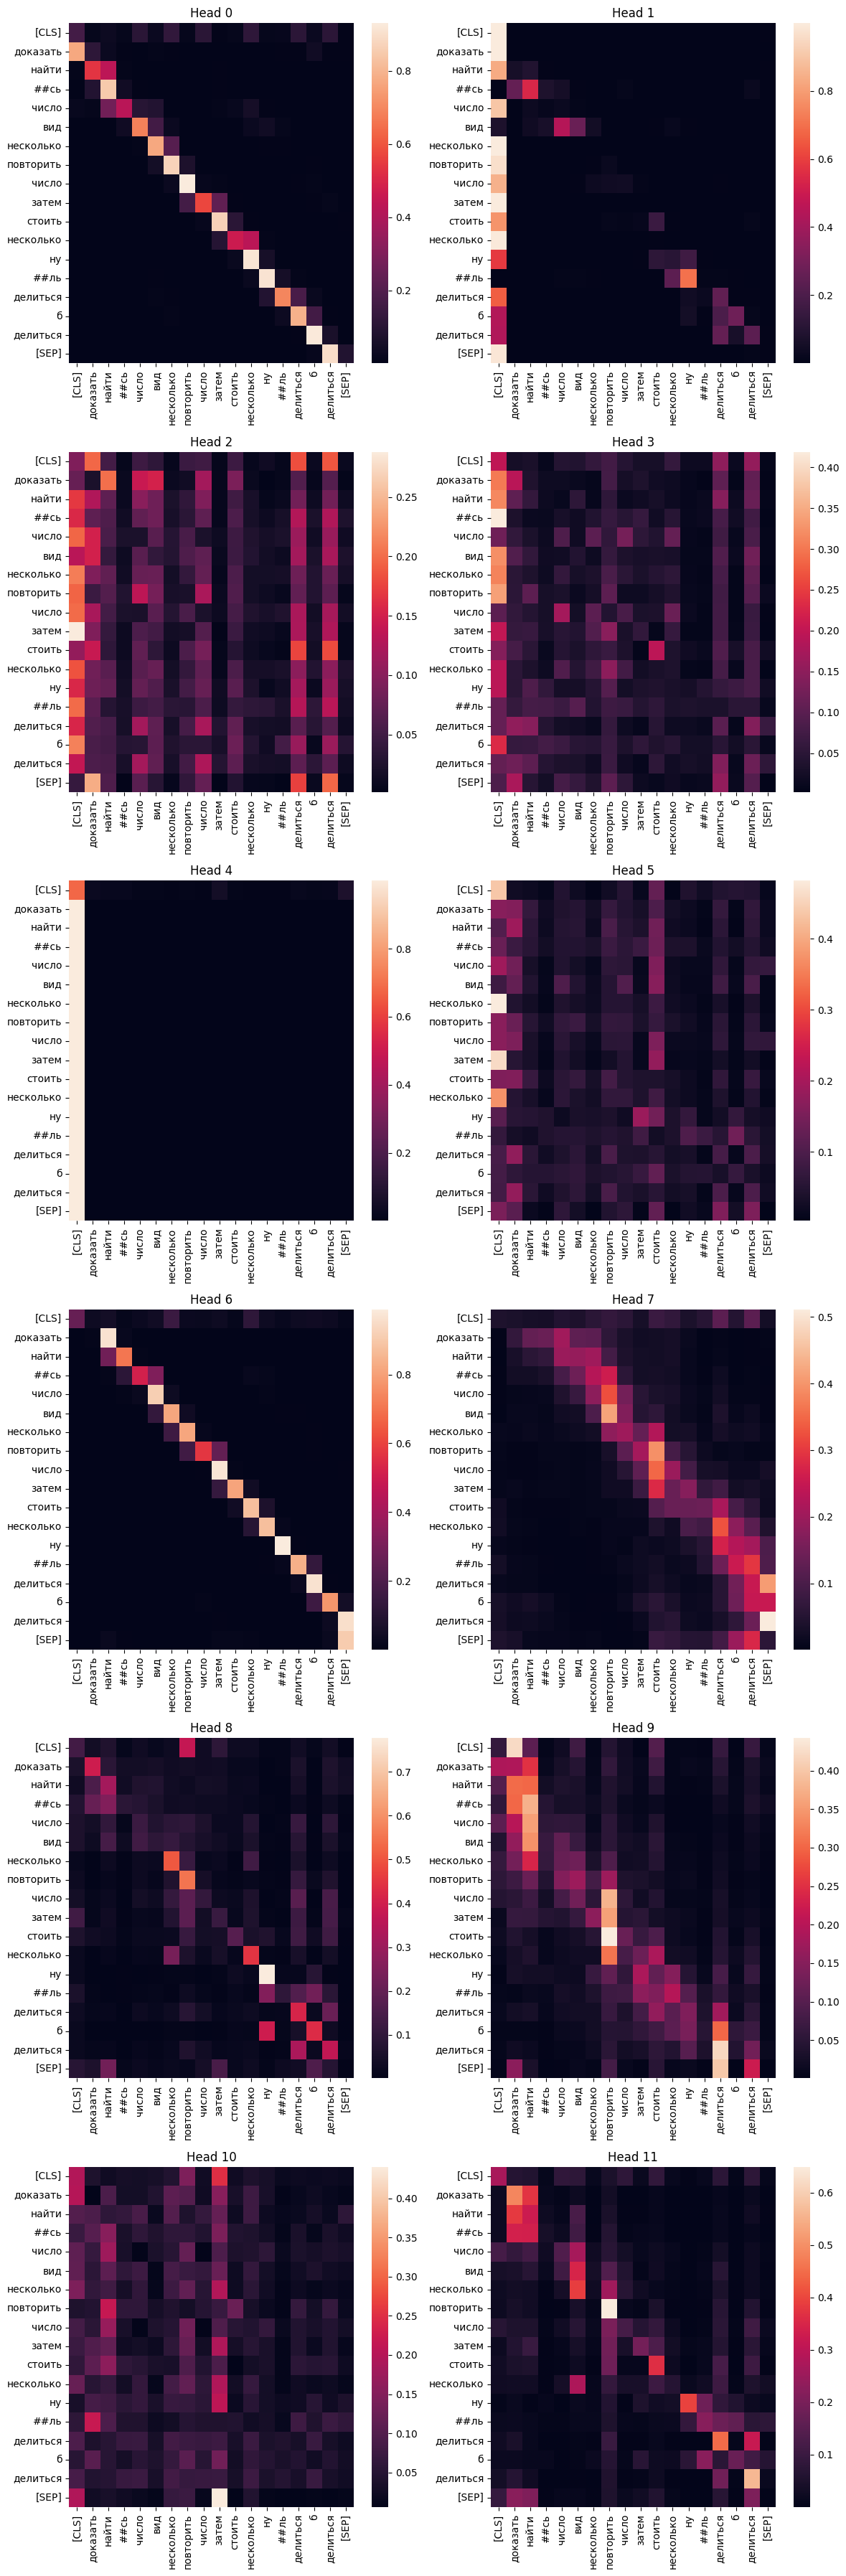

In [55]:
draw_first_layer_attention_maps(list(range(12)), texts_infer[0], rubert_tiny_transformer_model)    

В целом, видно, что не очень хорошо attention выделяется: много диагональных или около диагональных элементов.

Я выделил 1 и 10 головы: единственные головы, которые можно хоть как-то попытаться проинтерпретировать. 

1. Голова, когда была на слове `вид`, посмотрела на слово `число`. Вероятно, модель поняла о виде числа или чём-то подобном.
10. Голова, когда была на слове `повторить`, посмотрела на слово `найти`. 

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

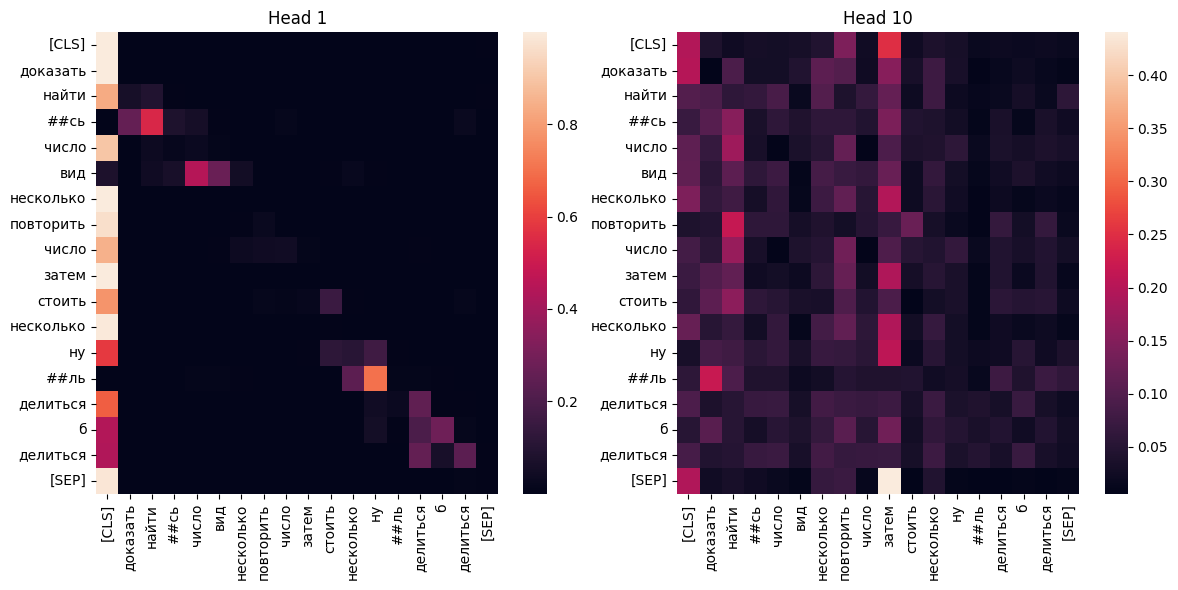

In [58]:
draw_first_layer_attention_maps([1, 10], texts_infer[0], rubert_tiny_transformer_model)   

### Проверим, что модель rubert, у которой мы заморозили backbone, карты внимания такие же, как у rubert, который мы не finetune.

Из графиков видно, что карты в точности одинаковые.

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

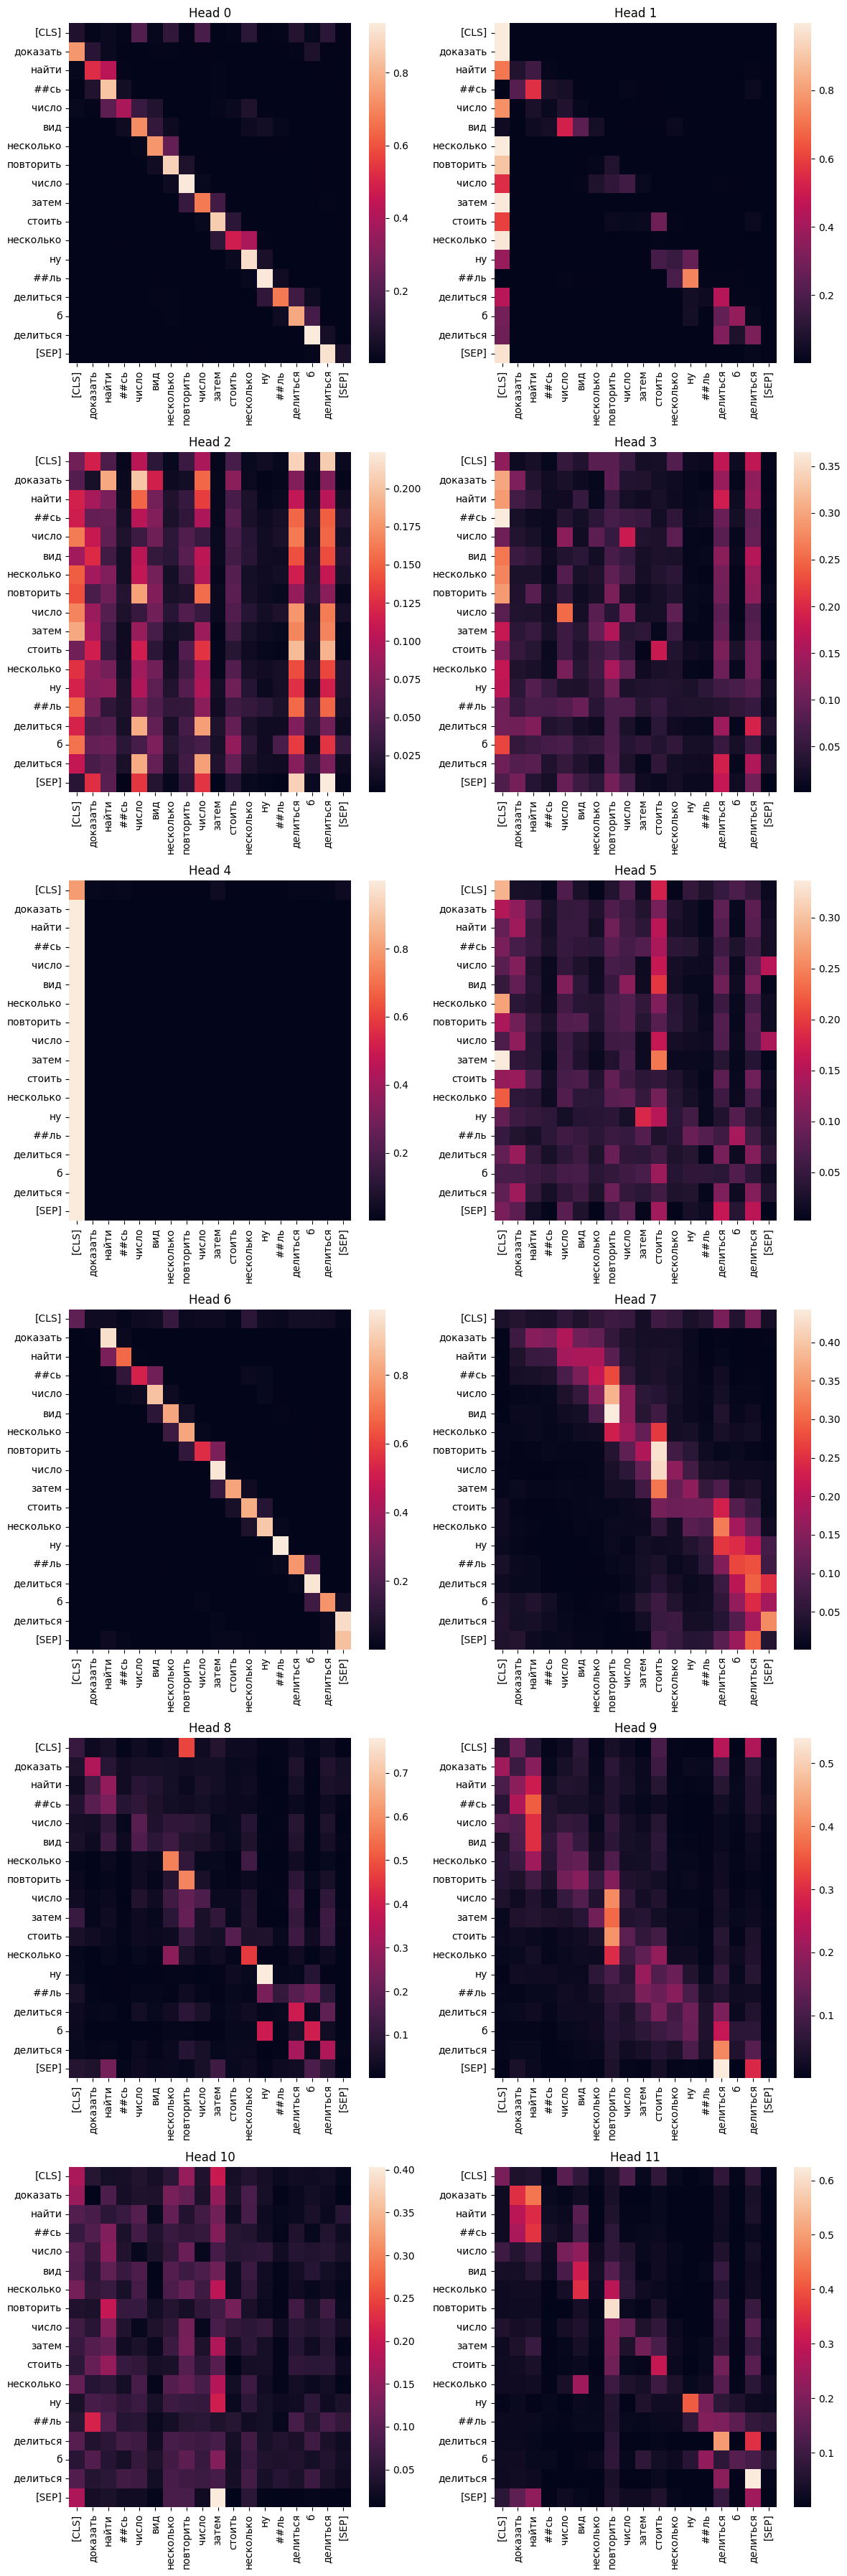

In [57]:
draw_first_layer_attention_maps(list(range(12)), texts_infer[0], rubert_tiny_finetuned_with_frozen_backbone)   

### Текст 2 

In [60]:
(texts_infer[1])

'доказать число n n иметь одинаковый сумма цифра n делиться'

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

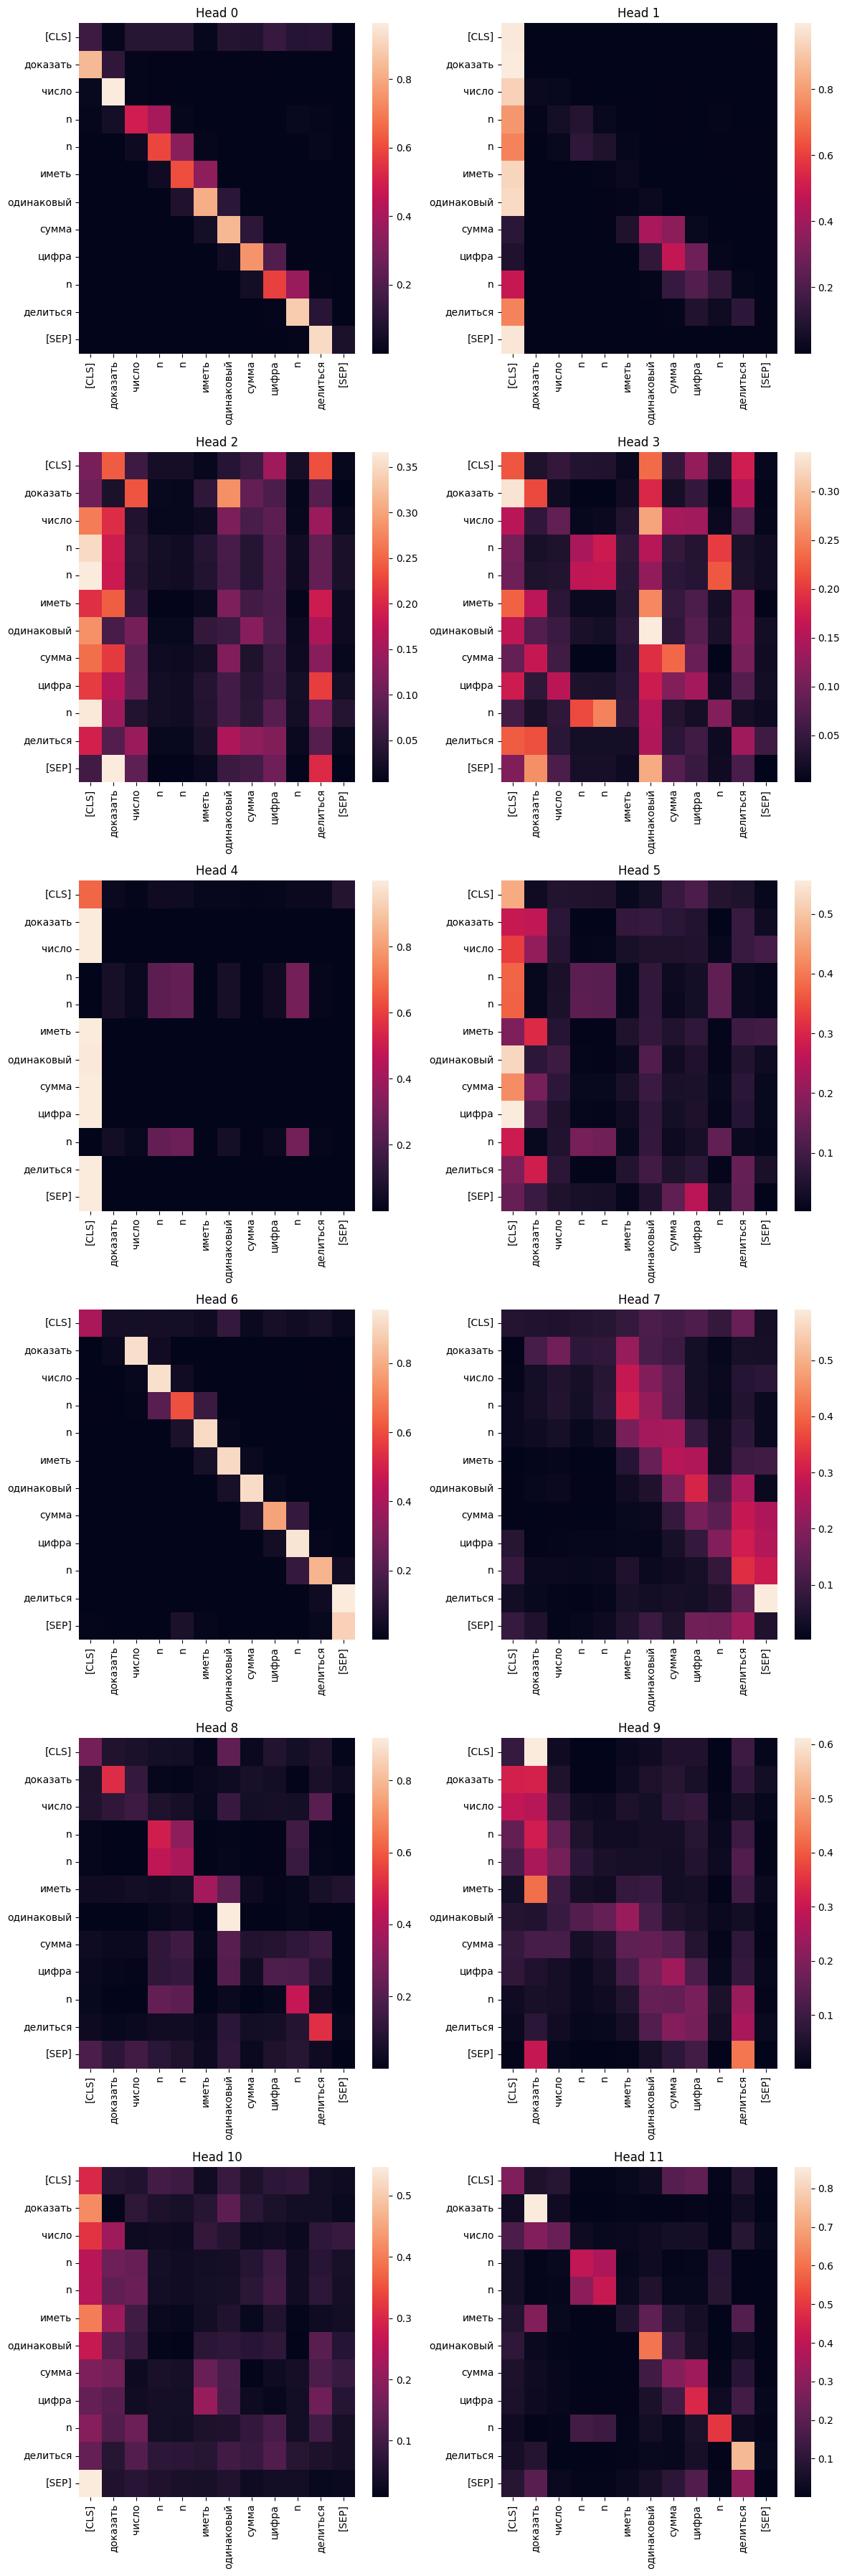

In [59]:
draw_first_layer_attention_maps(list(range(12)), texts_infer[1], rubert_tiny_transformer_model)   

Первая головая наиболее информативня

1. При нахождении на слове `сумма` голова обращает внимание на `одинаковый`, то есть одинаковая сумма.
2. При нахождении на слове `цифр` голова обращает внимание на `сумма`, то есть сумма цифр.

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

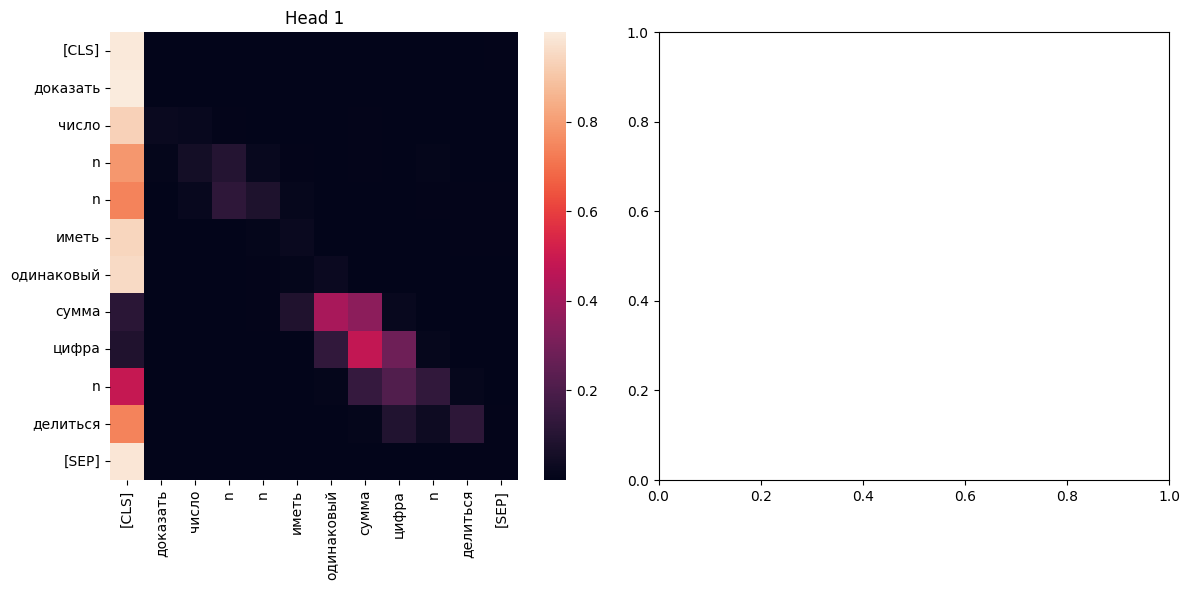

In [63]:
draw_first_layer_attention_maps([1], texts_infer[1], rubert_tiny_transformer_model) 

### Задание 8 (1 балл)

Сделайте то же самое для дообученной модели. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Для моделей, у который backbone был заморожен, бессмленно ещё раз карты внимания рисовать, так как они просто будут совпадать с моделями, которые мы не finetune (так как мы обучаем только параметры классификатора).

На самом деле, видно, что карты внимания очень похожи на недообученный bert. Предполагаю, что это связано с небольшим количеством эпох./

## Rubert

### Текст 1 

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

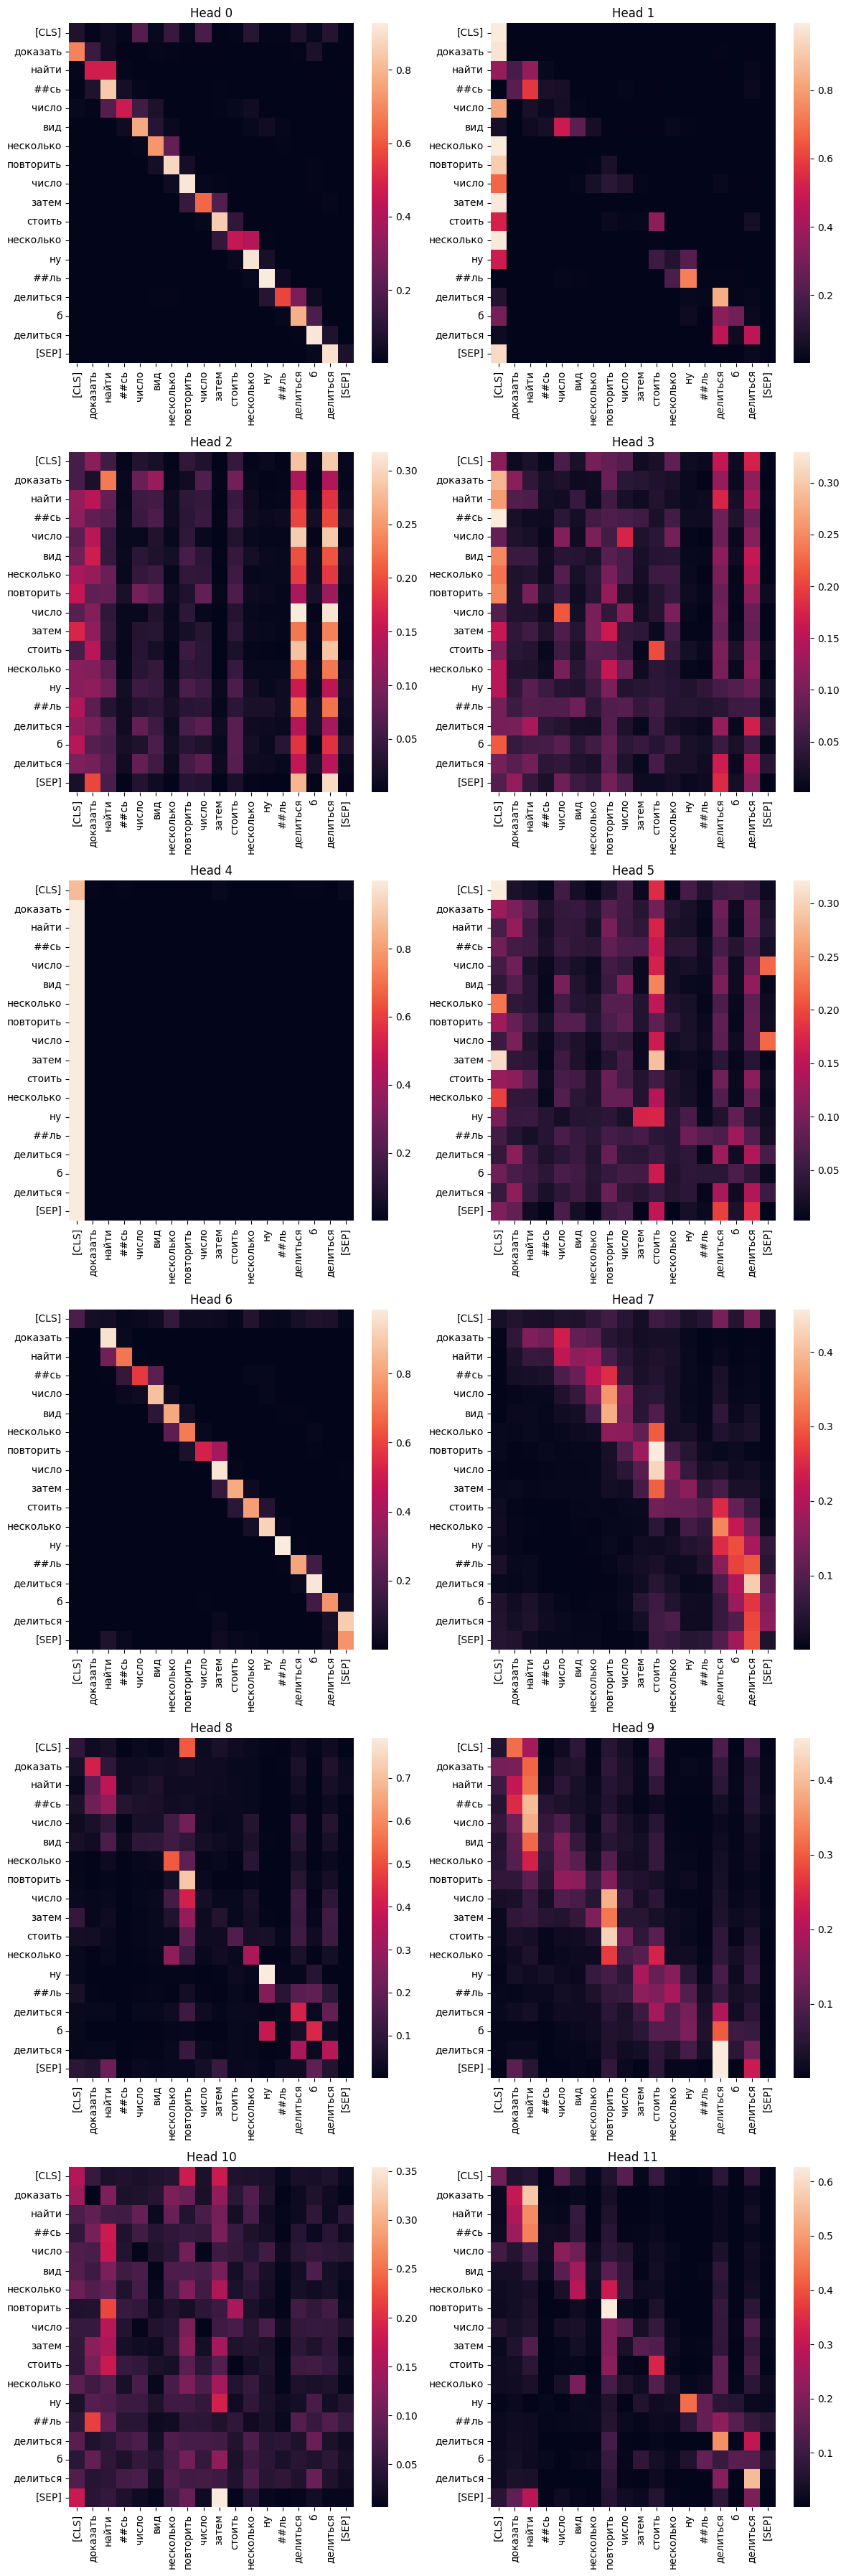

In [67]:
draw_first_layer_attention_maps(list(range(12)), texts_infer[0], rubert_tiny_finetuned_with_unfrozen_backbone) 

Я выбрал только 9 голову, как наиболее информативую.
1. Когда модель находится на слове `число`, она обращает внимание на слово `найти`. То есть, найти число.
2. Когда модель находится на другом слове `число`, она обращает внимание на слово `повторить`. То есть, повторить число.
Довольно интересный паттерн.

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

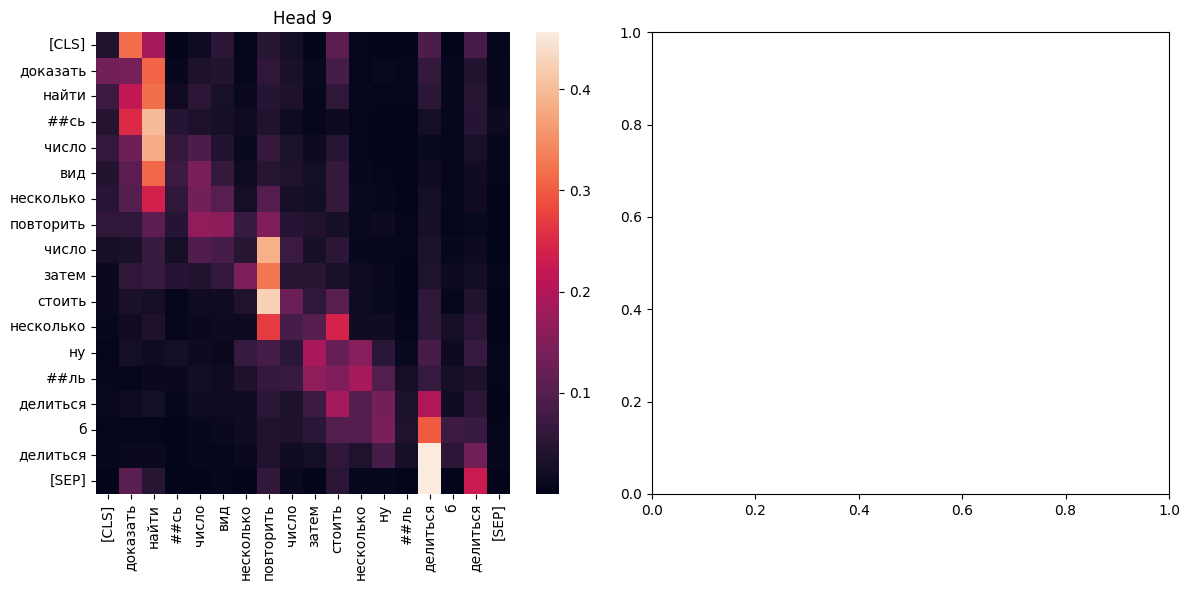

In [68]:
draw_first_layer_attention_maps([9], texts_infer[0], rubert_tiny_finetuned_with_unfrozen_backbone) 

### Текст 2

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

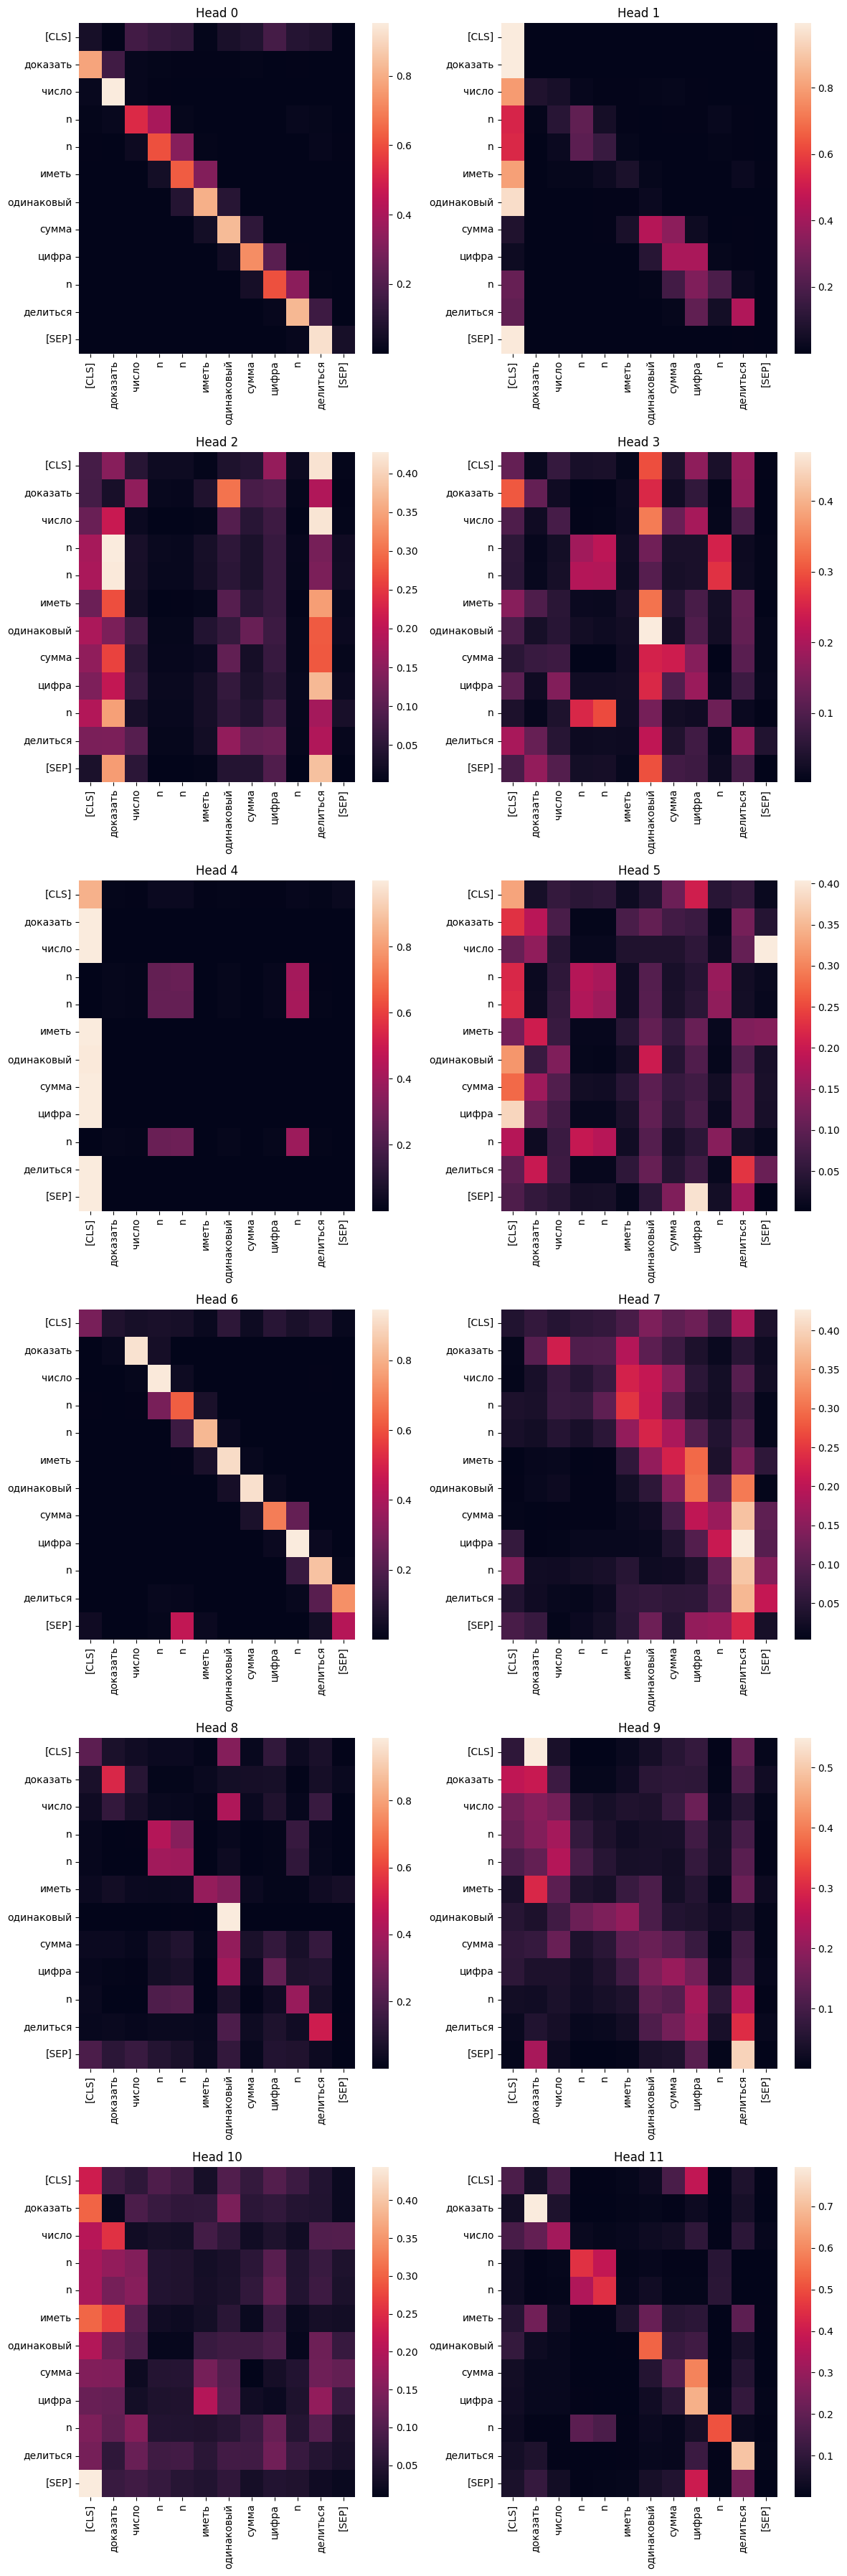

In [70]:
draw_first_layer_attention_maps(list(range(12)), texts_infer[1], rubert_tiny_finetuned_with_unfrozen_backbone) 

Я выбрал только 2-ю голову
1. Когда модель находится на слове `доказать`, она обращает внимание на слово `одинаковый`. То есть, доказать, что одинаковый.
2. Когда модель находится на другом слове `число`, она обращает внимание на слово `делиться`. То есть, число делится. Паттерн аналогичен тому, что я отмечал в 1-м тексте.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

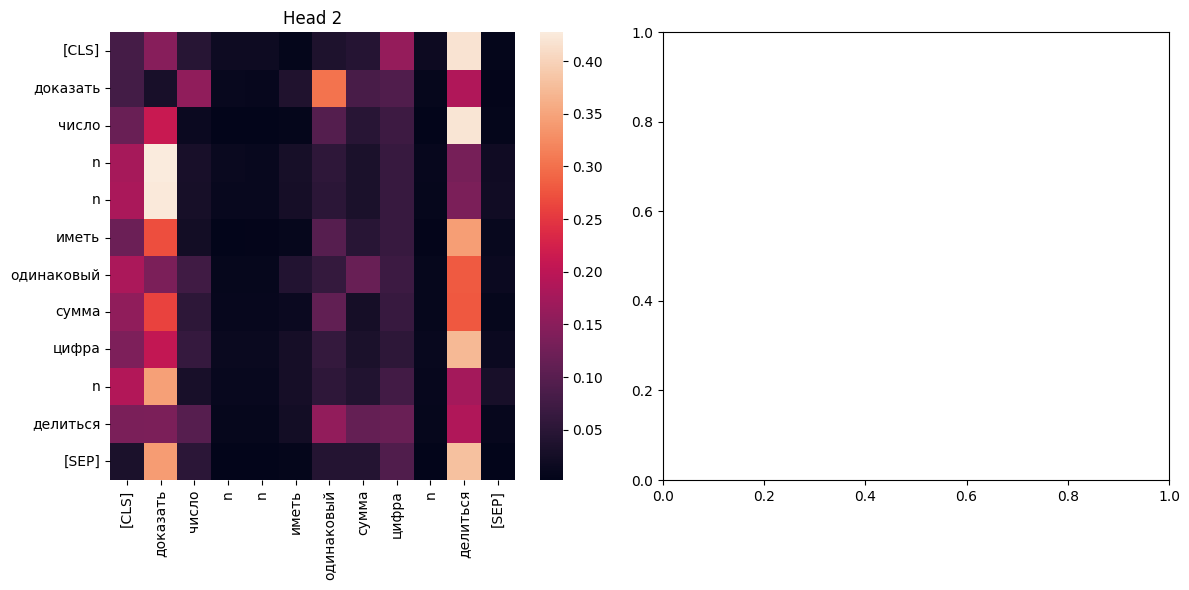

In [71]:
draw_first_layer_attention_maps([2], texts_infer[1], rubert_tiny_finetuned_with_unfrozen_backbone) 